# Particle Map of Coherence v2


v2: Combined figs from `G4_paper_map_figs.ipynb` and `particle_map_of_coherence.ipynb` for final euk paper maps

LJK

Date created: 08/11/25

Last edited: 08/11/25 

In [1]:
import math, ast, shapely
import numpy as np
import xarray as xr
import pandas as pd
from pyproj import Transformer, CRS

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from shapely import geometry
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union, transform

from config import *

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

### Load Chl-a Data

In [3]:
nov_chla = xr.open_dataset(data_dir +'OCCCI_data/CCI_ALL-v6.0-MONTHLY.nc')
nov_chla

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-01
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    chlor_a  (time, lat, lon) float32 ...
Attributes:
    Conventions:                       CF-1.7
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    creator_url:                       http://esa-oceancolour-cci.org
    geospatial_lat_max:                89.97916666666666
    geospatial_lat_min:                -89.97916666666666
    geospatial_lat_resolution:         .04166666666666666666
    geospatial_lat_units:              decimal degrees north
    geospatial_lon_max:                179.9791666666666
    geospatial_lon_min:                -179.97916666666666
    geospatial_lon_resolution:         .04166666666666666666
    geospatial_lon_units:              decimal degrees east
    geospatial_vertical_max:           0.0
    geospatial_vertical_min:           0.0
    git_commit_hash:                   ccd62ccbfe552e569fc0a9bbcb6f72fb5522843d
    institution:                       Plymouth Marine Laboratory
    keywords:                          satellite,observation,ocean,ocean colour
    keywords_vocabulary:               none
    naming_authority:                  uk.ac.pml
    number_of_bands_used_to_classify:  4
    number_of_optical_water_types:     14
    platform:                          Orbview-2,Aqua,Envisat,Suomi-NPP, Sent...
    processing_level:                  Level-3
    product_version:                   6.0
    sensor:                            SeaWiFS,MODIS,MERIS,VIIRS,OLCI
    sensors_present:                    OLCIa OLCIb
    source:                            NASA SeaWiFS  L1A and L2 R2018.0 LAC a...
    spatial_resolution:                4km nominal at equator
    standard_name_vocabulary:          NetCDF Climate and Forecast (CF) Metad...
    NCO:                               netCDF Operators version 4.7.5 (Homepa...
    license:                           ESA CCI, EOCIS, and C3S Data Policy: f...
    project:                           Climate Change Initiative - European S...
    references:                        https://climate.esa.int/en/projects/oc...
    title:                             ESA CCI, EOCIS Ocean Colour Product, a...
    number_of_files_composited:        28
    history:                           Source data were: ESACCI-OC-L3S-OC_PRO...
    summary:                           Data products generated by the Ocean C...
    tracking_id:                       576e0fa8-124f-4e16-8c11-85fee96f1493
    id:                                ESACCI-OC-L3S-OC_PRODUCTS-MERGED-1M_MO...
    creation_date:                     Thu Apr 24 11:36:24 2025
    date_created:                      Thu Apr 24 11:36:24 2025
    time_coverage_resolution:          P1M
    time_coverage_duration:            P1M
    start_date:                        01-FEB-2025 00:00:00.000000
    stop_date:                         28-FEB-2025 23:59:00.000000
    time_coverage_start:               202502010000Z
    time_coverage_end:                 202502282359Z
    History:                           Translated to CF-1.0 Conventions by Ne...

In [4]:
def wrap_and_crop_nc_file(ds,min_lat,max_lat,min_lon,max_lon):
    """
    Wrap the dataset so that it is centered on the Pacific Ocean (-180/180), and then crop
    """    
    
    # Crop latitude bounds
    mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
    ds_crop = ds.where(mask_lat, drop=True) 
    
    # Divide data into west and east halves
    mask_lon_east = (ds_crop.lon <= 0)
    ds_crop_east = ds_crop.where(mask_lon_east, drop=True)
    ds_crop_east['lon'] = [l+360 for l in ds_crop_east['lon']] # convert negative coordinates to positive
    
    mask_lon_west = (ds_crop.lon > 0)
    ds_crop_west = ds_crop.where(mask_lon_west, drop=True)
    
    # Re-combine west and east so that it is cented on the Pacific
    ds_wrapped = xr.concat([ds_crop_west, ds_crop_east], dim="lon")

    # Crop longitude bounds
    mask_lon = (ds_wrapped.lon >= min_lon) & (ds_wrapped.lon <= max_lon)
    ds_wrapped_crop = ds_wrapped.where(mask_lon, drop=True)
    
    # Save dataset
    #ds_wrapped_crop.to_netcdf(new_dir + file[:-3] + '_bounding_box.nc')
    return ds_wrapped_crop

In [5]:
lat_min,lat_max = -5,50
lon_min,lon_max = 120,260
ds_wrapped_crop = wrap_and_crop_nc_file(nov_chla,lat_min,lat_max,lon_min,lon_max)

In [6]:
metadata_df = pd.read_csv(data_dir  + 'AVISO_eddies/AVISO_metadata_15km_near_eddy.csv',index_col=0)

/home/jonesae/.conda/envs/py3_parcels_v2/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


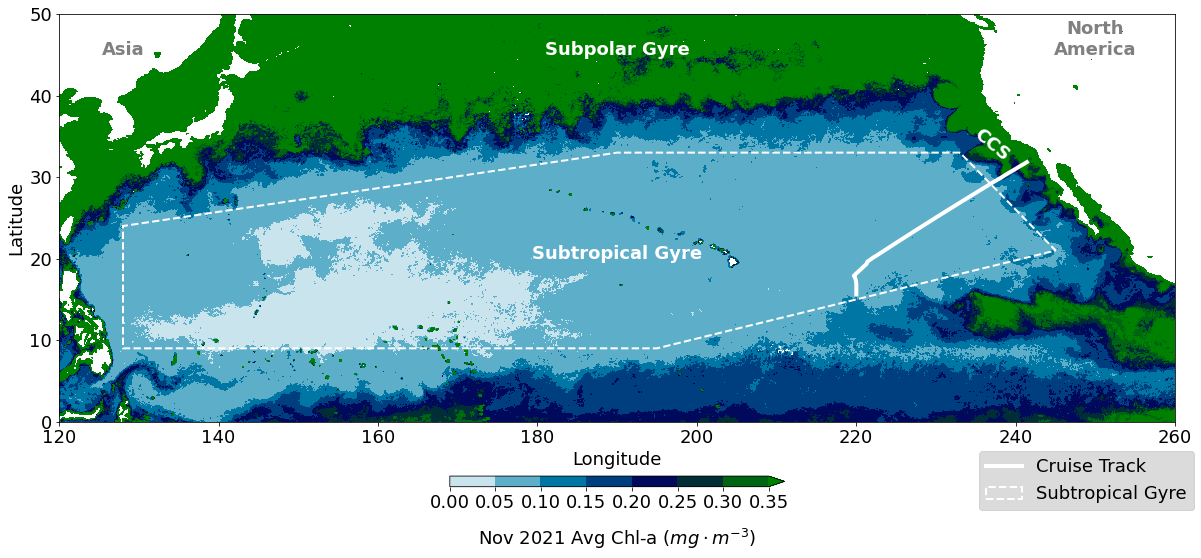

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

vmin,vmax=0,0.35
levels = np.linspace(vmin, vmax,8) 

plot = ax.contourf(ds_wrapped_crop.lon,ds_wrapped_crop.lat,ds_wrapped_crop.chlor_a[0],levels=levels,
                  vmin=vmin,vmax=vmax, extend='max',cmap='ocean_r')

polygon = [[233, 33], [190, 33], [128, 24], [128, 9], [195, 9], [245, 21], [233,33]]
polygon_plot = patches.Polygon(polygon, closed=True,facecolor='none', edgecolor='w',linestyle='--',linewidth=2,label='Subtropical Gyre')
ax.add_patch(polygon_plot)

ax.plot(metadata_df.longitude,metadata_df.latitude,c='w',linewidth=4,label='Cruise Track')
cbar = plt.colorbar(plot,ax=ax,orientation='horizontal',pad=0.1,aspect=30,extend='max',shrink=0.3)
cbar.set_label('Nov 2021 Avg Chl-a ($mg\cdot m^{-3}$)',labelpad=15)

ax.set_xlim([lon_min,lon_max])
ax.set_ylim([0,50])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.legend(bbox_to_anchor=(1.025,-0.05),facecolor='lightgray') 

ax.text(190,45,'Subpolar Gyre',horizontalalignment='center',fontweight='bold',c='w')
ax.text(190,20,'Subtropical Gyre',horizontalalignment='center',fontweight='bold',c='w')
ax.text(237,32,'CCS',horizontalalignment='center',fontweight='bold',c='w',rotation=320)
ax.text(128,45,'Asia',horizontalalignment='center',fontweight='bold',c='gray')
ax.text(250,45,'North\nAmerica',horizontalalignment='center',fontweight='bold',c='gray')


plt.show()

### Load eddy bounds

In [8]:
ds_anti = xr.open_dataset(AVISO_dir + 'META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc')
ds_cyc = xr.open_dataset(AVISO_dir + 'META3.2_DT_allsat_Cyclonic_long_19930101_20220209.nc')
ds_anti

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 34521490)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    effective_radius               (obs) float32 ...
    inner_contour_height           (obs) float32 ...
    latitude                       (obs) float32 ...
    latitude_max                   (obs) float32 ...
    longitude                      (obs) float32 ...
    longitude_max                  (obs) float32 ...
    num_contours                   (obs) uint16 ...
    num_point_e                    (obs) uint16 ...
    num_point_s                    (obs) uint16 ...
    observation_flag               (obs) int8 ...
    observation_number             (obs) uint16 ...
    speed_area                     (obs) float32 ...
    speed_average                  (obs) float32 ...
    speed_contour_height           (obs) float32 ...
    speed_contour_latitude         (obs, NbSample) float32 ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] ...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [9]:
def crop_AVISO_ds(eddy_ds,date,lat_min,lat_max,lon_min,lon_max):
    # Crop to the date of interest
    mask_time = (eddy_ds.time == np.datetime64(date))
    ds_crop_time = eddy_ds.where(mask_time, drop=True) 
    
    # Crop based on lat/lon bounds
    mask_lat_lon = ((ds_crop_time.latitude > lat_min) & (ds_crop_time.latitude < lat_max) & 
                (ds_crop_time.longitude > lon_min) & (ds_crop_time.longitude < lon_max))
    ds_crop_bounds = ds_crop_time.where(mask_lat_lon, drop=True) 
    
    return ds_crop_bounds

In [10]:
ds_anti_crop = crop_AVISO_ds(ds_anti,'2021-11-23',lat_min,lat_max,lon_min,lon_max)
ds_anti_crop

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 510)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 0.0547 0.3354 ... 0.01 0.031
    cost_association               (obs) float32 0.05824 0.2502 ... 0.196 0.3533
    effective_area                 (obs) float32 1.234e+10 ... 2.562e+09
    effective_contour_height       (obs) float32 0.004 0.038 ... 0.128 0.178
    effective_contour_latitude     (obs, NbSample) float32 47.79 47.71 ... 38.22
    effective_contour_longitude    (obs, NbSample) float32 218.1 218.4 ... 173.9
    effective_contour_shape_error  (obs) float32 22.5 33.5 31.0 ... 58.5 55.0
    effective_radius               (obs) float32 6.415e+04 ... 3.555e+04
    inner_contour_height           (obs) float32 0.058 0.372 ... 0.138 0.208
    latitude                       (obs) float32 48.26 46.28 ... 31.02 38.78
    latitude_max                   (obs) float32 48.15 46.37 ... 31.12 38.86
    longitude                      (obs) float32 218.5 154.3 ... 176.6 173.9
    longitude_max                  (obs) float32 218.4 154.4 ... 176.6 173.9
    num_contours                   (obs) float64 28.0 168.0 8.0 ... 5.0 6.0 16.0
    num_point_e                    (obs) float64 23.0 37.0 21.0 ... 13.0 13.0
    num_point_s                    (obs) float64 17.0 21.0 21.0 ... 13.0 13.0
    observation_flag               (obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    observation_number             (obs) float64 1.028e+03 616.0 ... 0.0 0.0
    speed_area                     (obs) float32 5.073e+09 ... 2.308e+09
    speed_average                  (obs) float32 0.1164 0.5174 ... 0.1424 0.2114
    speed_contour_height           (obs) float32 0.028 0.196 ... 0.128 0.18
    speed_contour_latitude         (obs, NbSample) float32 47.86 47.86 ... 38.34
    speed_contour_longitude        (obs, NbSample) float32 218.4 218.6 ... 173.9
    speed_contour_shape_error      (obs) float32 18.0 13.5 31.0 ... 58.5 49.5
    speed_radius                   (obs) float32 4.07e+04 5.015e+04 ... 3.15e+04
    time                           (obs) datetime64[ns] 2021-11-23 ... 2021-1...
    track                          (obs) float64 7.22e+05 ... 8.007e+05
    uavg_profile                   (obs, NbSample) float32 0.095 ... 0.0938
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [11]:
ds_cyc_crop = crop_AVISO_ds(ds_cyc,'2021-11-23',lat_min,lat_max,lon_min,lon_max)
ds_cyc_crop

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 541)
Dimensions without coordinates: NbSample, obs
Data variables:
    amplitude                      (obs) float32 0.0923 0.1156 ... 0.0089 0.0109
    cost_association               (obs) float32 0.07579 0.08304 ... 0.08999
    effective_area                 (obs) float32 5.375e+10 ... 3.171e+09
    effective_contour_height       (obs) float32 -0.012 -0.058 ... -0.068 -0.112
    effective_contour_latitude     (obs, NbSample) float32 24.86 24.99 ... 41.34
    effective_contour_longitude    (obs, NbSample) float32 213.4 213.1 ... 163.9
    effective_contour_shape_error  (obs) float32 8.0 18.5 23.5 ... 58.0 38.5
    effective_radius               (obs) float32 1.312e+05 ... 3.36e+04
    inner_contour_height           (obs) float32 -0.104 -0.172 ... -0.076 -0.122
    latitude                       (obs) float32 26.34 22.39 ... 9.844 41.63
    latitude_max                   (obs) float32 26.37 22.38 ... 9.885 41.63
    longitude                      (obs) float32 213.7 192.9 ... 220.8 164.0
    longitude_max                  (obs) float32 213.7 192.9 ... 220.8 163.9
    num_contours                   (obs) float64 47.0 58.0 105.0 ... 3.0 5.0 6.0
    num_point_e                    (obs) float64 41.0 33.0 59.0 ... 23.0 11.0
    num_point_s                    (obs) float64 21.0 21.0 21.0 ... 15.0 11.0
    observation_flag               (obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    observation_number             (obs) float64 640.0 462.0 400.0 ... 0.0 0.0
    speed_area                     (obs) float32 1.287e+10 ... 3.171e+09
    speed_average                  (obs) float32 0.1482 0.2659 ... 0.2814 0.083
    speed_contour_height           (obs) float32 -0.064 -0.1 ... -0.072 -0.112
    speed_contour_latitude         (obs, NbSample) float32 25.86 25.89 ... 41.34
    speed_contour_longitude        (obs, NbSample) float32 213.1 213.1 ... 163.9
    speed_contour_shape_error      (obs) float32 15.0 11.5 12.0 ... 55.5 38.5
    speed_radius                   (obs) float32 6.455e+04 7.24e+04 ... 3.36e+04
    time                           (obs) datetime64[ns] 2021-11-23 ... 2021-1...
    track                          (obs) float64 7.977e+05 ... 8.493e+05
    uavg_profile                   (obs, NbSample) float32 0.1178 ... 0.0432
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Cyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T23:14:21Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [12]:
def crop_eddy_ds_to_polygon_boundary(eddy_ds,polygon):

    lats,lons = eddy_ds['latitude'].values, eddy_ds['longitude'].values

    # Flatten to apply polygon test
    points = np.column_stack((lons.ravel(), lats.ravel()))
    mask_flat = np.array([polygon.contains(Point(p)) for p in points])

    # Reshape back to the original shape & convert into a DataArray
    mask_da = xr.DataArray(mask_flat.reshape(lats.shape),
                        dims = eddy_ds['latitude'].dims,  # likely ('obs', 'NbSample')
                        coords = {dim: eddy_ds.coords[dim] for dim in eddy_ds['latitude'].dims})

    # Apply mask to the full dataset
    eddy_ds_in_poly = eddy_ds.where(mask_da, drop=True)
    
    return eddy_ds_in_poly

In [13]:
polygon_shapely = Polygon(polygon)
anti_ds_in_poly = crop_eddy_ds_to_polygon_boundary(ds_anti_crop, polygon_shapely)
anti_ds_in_poly

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 187)
Coordinates:
  * obs                            (obs) int64 6 7 8 11 13 ... 498 499 504 508
Dimensions without coordinates: NbSample
Data variables:
    amplitude                      (obs) float32 0.0322 0.0852 ... 0.0071 0.01
    cost_association               (obs) float32 0.1053 0.08245 ... 0.3936 0.196
    effective_area                 (obs) float32 6.137e+09 ... 1.993e+09
    effective_contour_height       (obs) float32 0.026 0.044 ... 0.026 0.128
    effective_contour_latitude     (obs, NbSample) float32 31.19 31.15 ... 30.84
    effective_contour_longitude    (obs, NbSample) float32 224.1 224.4 ... 176.1
    effective_contour_shape_error  (obs) float32 23.5 25.0 22.5 ... 47.0 58.5
    effective_radius               (obs) float32 4.51e+04 1.090e+05 ... 3.06e+04
    inner_contour_height           (obs) float32 0.058 0.128 ... 0.032 0.138
    latitude                       (obs) float32 31.48 26.55 ... 22.51 31.02
    latitude_max                   (obs) float32 31.38 26.62 ... 22.38 31.12
    longitude                      (obs) float32 224.4 153.9 ... 166.2 176.6
    longitude_max                  (obs) float32 224.4 153.7 ... 166.4 176.6
    num_contours                   (obs) float64 17.0 43.0 3.0 ... 3.0 4.0 6.0
    num_point_e                    (obs) float64 13.0 37.0 13.0 ... 13.0 13.0
    num_point_s                    (obs) float64 11.0 25.0 13.0 ... 13.0 13.0
    observation_flag               (obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    observation_number             (obs) float64 393.0 365.0 338.0 ... 0.0 0.0
    speed_area                     (obs) float32 2.524e+09 ... 1.993e+09
    speed_average                  (obs) float32 0.1274 0.1754 ... 0.0978 0.1424
    speed_contour_height           (obs) float32 0.04 0.078 ... 0.026 0.128
    speed_contour_latitude         (obs, NbSample) float32 31.32 31.25 ... 30.84
    speed_contour_longitude        (obs, NbSample) float32 224.1 224.4 ... 176.1
    speed_contour_shape_error      (obs) float32 19.5 19.5 22.5 ... 47.0 58.5
    speed_radius                   (obs) float32 2.875e+04 7.41e+04 ... 3.06e+04
    time                           (obs) datetime64[ns] 2021-11-23 ... 2021-1...
    track                          (obs) float64 7.706e+05 ... 8.007e+05
    uavg_profile                   (obs, NbSample) float32 0.1185 ... 0.1794
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [14]:
cyc_ds_in_poly = crop_eddy_ds_to_polygon_boundary(ds_cyc_crop,polygon_shapely)
cyc_ds_in_poly

<xarray.Dataset>
Dimensions:                        (NbSample: 20, obs: 203)
Coordinates:
  * obs                            (obs) int64 0 1 2 5 6 ... 528 531 534 535 537
Dimensions without coordinates: NbSample
Data variables:
    amplitude                      (obs) float32 0.0923 0.1156 ... 0.005 0.0068
    cost_association               (obs) float32 0.07579 0.08304 ... 0.2708
    effective_area                 (obs) float32 5.375e+10 ... 2.402e+09
    effective_contour_height       (obs) float32 -0.012 -0.058 ... -0.032 -0.066
    effective_contour_latitude     (obs, NbSample) float32 24.86 24.99 ... 20.86
    effective_contour_longitude    (obs, NbSample) float32 213.4 213.1 ... 199.6
    effective_contour_shape_error  (obs) float32 8.0 18.5 23.5 ... 36.0 32.5
    effective_radius               (obs) float32 1.312e+05 ... 2.95e+04
    inner_contour_height           (obs) float32 -0.104 -0.172 ... -0.036 -0.072
    latitude                       (obs) float32 26.34 22.39 ... 14.67 20.99
    latitude_max                   (obs) float32 26.37 22.38 ... 14.63 21.01
    longitude                      (obs) float32 213.7 192.9 ... 196.6 199.9
    longitude_max                  (obs) float32 213.7 192.9 ... 196.6 199.9
    num_contours                   (obs) float64 47.0 58.0 105.0 ... 3.0 3.0 4.0
    num_point_e                    (obs) float64 41.0 33.0 59.0 ... 13.0 11.0
    num_point_s                    (obs) float64 21.0 21.0 21.0 ... 13.0 11.0
    observation_flag               (obs) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    observation_number             (obs) float64 640.0 462.0 400.0 ... 0.0 0.0
    speed_area                     (obs) float32 1.287e+10 ... 2.402e+09
    speed_average                  (obs) float32 0.1482 0.2659 ... 0.185 0.1074
    speed_contour_height           (obs) float32 -0.064 -0.1 ... -0.032 -0.066
    speed_contour_latitude         (obs, NbSample) float32 25.86 25.89 ... 20.86
    speed_contour_longitude        (obs, NbSample) float32 213.1 213.1 ... 199.6
    speed_contour_shape_error      (obs) float32 15.0 11.5 12.0 ... 36.0 32.5
    speed_radius                   (obs) float32 6.455e+04 7.24e+04 ... 2.95e+04
    time                           (obs) datetime64[ns] 2021-11-23 ... 2021-1...
    track                          (obs) float64 7.977e+05 ... 8.493e+05
    uavg_profile                   (obs, NbSample) float32 0.1178 ... 0.0839
Attributes:
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Cyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T23:14:21Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

Save eddy data subset

In [15]:
#anti_ds_in_poly.to_netcdf(data_dir + 'META3.2_DT_allsat_Anticyclonic_long_20211123_NPSG_poly.nc')
#cyc_ds_in_poly.to_netcdf(data_dir + 'META3.2_DT_allsat_Cyclonic_long_20211123_NPSG_poly.nc')

Convert the individual eddy polygons into a single one; easier for determining whether a particle is in or out of an eddy

In [16]:
eddy_polys = []
for eddy_ds in [anti_ds_in_poly,cyc_ds_in_poly]:
    for i in np.arange(0,len(eddy_ds.obs)):
        contour_lons = eddy_ds.effective_contour_longitude[i]
        contour_lats = eddy_ds.effective_contour_latitude[i]
        point_stack = np.column_stack((contour_lons.values.ravel(), contour_lats.values.ravel())).tolist()
        eddy_polys.append(Polygon(point_stack))

# One poly to rule them all
unifying_poly = unary_union(eddy_polys)

### 15km Buffer Around Eddies

Need to use a projection appropriate for the region to get a buffer around each eddy

In [17]:
def buffer_eddy_polygon(poly):
    """
    poly: a single eddy polygon in shapely format
    
    15km buffer around the eddy polygon using an Azimuthal Equidistant projection centered on the eddy
    """
    
    # Project the polygon from WGS84 to a Pacific coordinate projection
    center_lon, center_lat = poly.centroid.coords[0] # gets eddy center coords for the projection
    crs_pacific = CRS.from_proj4(f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +datum=WGS84 +units=m +no_defs")
    crs_wgs84 = CRS.from_epsg(4326) # EPSG code for the WGS84 coordinate system
    to_proj = Transformer.from_crs(crs_wgs84, crs_pacific, always_xy=True).transform
    poly_proj = transform(to_proj, poly)
        
    # Add a 10km buffer to the polgon using the new projection, then covert back to WGS84
    poly_buffered = poly_proj.buffer(15_000)  # 15 km buffer (function expects meters)
    from_proj = Transformer.from_crs(crs_pacific, crs_wgs84, always_xy=True).transform
    poly_WGS84_wbuffer = transform(from_proj, poly_buffered)
    
    # Convert back to 360 again; necessary or polys across the dateline will be invalid 
    def shift_coords(coords):
        return [((x + 360 if x < 0 else x), y) for x, y in coords]

    exterior = shift_coords(poly_WGS84_wbuffer.exterior.coords)
    interiors = [shift_coords(ring.coords) for ring in poly_WGS84_wbuffer.interiors]
    final_poly = Polygon(exterior, interiors)
    
    return final_poly

In [18]:
buff15km_eddy_polys = [buffer_eddy_polygon(poly) for poly in eddy_polys]
len(buff15km_eddy_polys)

390

Checks 

In [19]:
invalid_polys = [g for g in buff15km_eddy_polys if not g.is_valid]
print(len(invalid_polys))

empty_polys = [g for g in buff15km_eddy_polys if g.is_empty]
print(len(empty_polys))

0
0


In [20]:
def plot_filled_eddy(a,eddy_ds,fill_color,label):
    for i in np.arange(0,len(eddy_ds.obs)):
        contour_lons = eddy_ds.effective_contour_longitude[i]
        contour_lats = eddy_ds.effective_contour_latitude[i]
        point_stack = np.column_stack((contour_lons.values.ravel(), contour_lats.values.ravel())).tolist()
        if i == 0:
            eddy_poly = patches.Polygon(point_stack, closed=True, facecolor=fill_color, edgecolor=None, label=label)
        else:
            eddy_poly = patches.Polygon(point_stack, closed=True, facecolor=fill_color, edgecolor=None)
            
        a.add_patch(eddy_poly)

/home/jonesae/.conda/envs/py3_parcels_v2/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


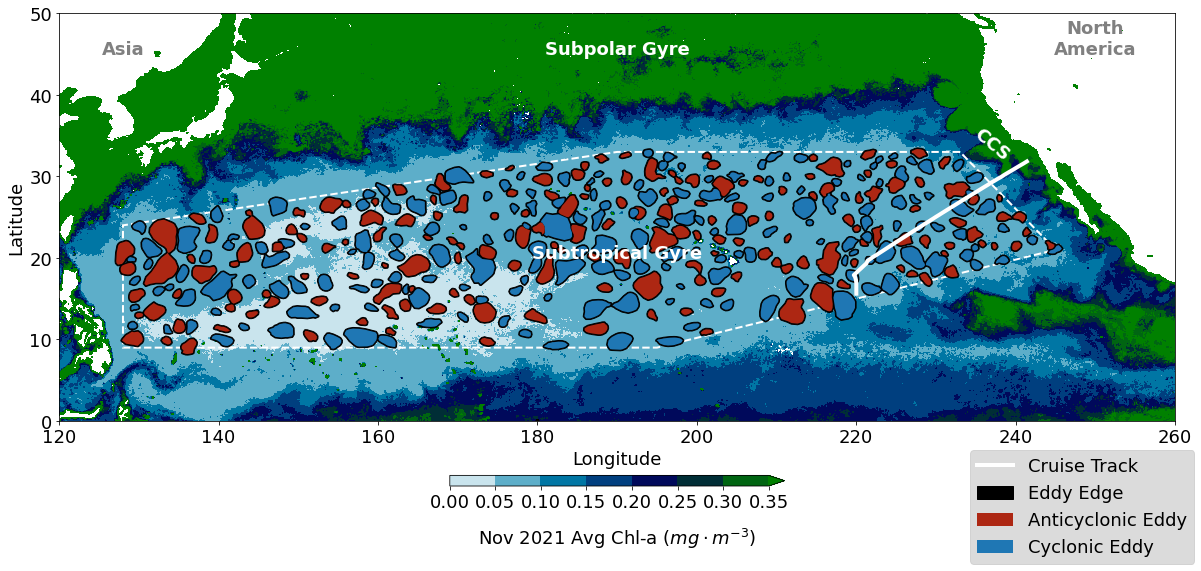

In [22]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

vmin,vmax=0,0.35
levels = np.linspace(vmin, vmax,8) 

plot = ax.contourf(ds_wrapped_crop.lon,ds_wrapped_crop.lat,ds_wrapped_crop.chlor_a[0],levels=levels,
                  vmin=vmin,vmax=vmax, extend='max',cmap='ocean_r')

polygon = [[233, 33], [190, 33], [128, 24], [128, 9], [195, 9], [245, 21], [233,33]]
polygon_plot = patches.Polygon(polygon, closed=True,facecolor='none', edgecolor='w',linestyle='--',linewidth=2)
ax.add_patch(polygon_plot)

ax.plot(metadata_df.longitude,metadata_df.latitude,c='w',linewidth=4,label='Cruise Track')
cbar = plt.colorbar(plot,ax=ax,orientation='horizontal',pad=0.1,aspect=30,extend='max',shrink=0.3)
cbar.set_label('Nov 2021 Avg Chl-a ($mg\cdot m^{-3}$)',labelpad=15)

ax.set_xlim([lon_min,lon_max])
ax.set_ylim([0,50])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


######## EDDIES ########
count = 0
for poly in buff15km_eddy_polys:
    x, y = poly.exterior.xy
    if count == 0:
        polygon_patch = patches.Polygon(list(zip(x, y)), closed=True, color='k',label='Eddy Edge')
    else:
        polygon_patch = patches.Polygon(list(zip(x, y)), closed=True, color='k')
    
    ax.add_patch(polygon_patch)
    count += 1

plot_filled_eddy(ax,anti_ds_in_poly,'#ad2713','Anticyclonic Eddy')
plot_filled_eddy(ax,cyc_ds_in_poly,'C0','Cyclonic Eddy')

#plot_hatched_eddy(anti_ds_in_poly,'#ad2713','Anticyclonic Eddy')
#plot_hatched_eddy(cyc_ds_in_poly,'C0','Cyclonic Eddy')

########################


plt.legend(bbox_to_anchor=(1.025,-0.05),facecolor='lightgray') 

ax.text(190,45,'Subpolar Gyre',horizontalalignment='center',fontweight='bold',c='w')
ax.text(190,20,'Subtropical Gyre',horizontalalignment='center',fontweight='bold',c='w')
ax.text(237,32,'CCS',horizontalalignment='center',fontweight='bold',c='w',rotation=320)
ax.text(128,45,'Asia',horizontalalignment='center',fontweight='bold',c='gray')
ax.text(250,45,'North\nAmerica',horizontalalignment='center',fontweight='bold',c='gray')

plt.show()

### Load Plankton Data

Using the unfiltered data (includes rare phytoplankton)

In [23]:
ASV_df = pd.read_csv(data_dir + '221118-1309_LexiGradients-HighCov_2.09-fold-18S-correction_normalized_sequence_counts_abs_ASV_abundance_IS_avg_station_avg.tsv',index_col=0).transpose()
ASV_df = ASV_df.drop(['63','65']) # drop sample sites not using in analysis
ASV_df

,e9f376c867c2a1506d5b0996f9839a20,86cd70d2450e3f44f4a7c543f53008ee,0e775fc1584ed21db02c44461c5e120e,d089e76cb77366eba904ed413876e849,1ce3b5c6d85ce967f8677e23e3e9b0be,401a67858704d406087efd35334e84e1,13eea987393ec9079bd9805404f0d4b3,0b1c2b9ed02095f223b442c9bdd35006,4b9f1fbd0c8921c969e9bf162cf1d520,4f8257e5a38397d186bc493c97412d42,...,8e59aa4a15ef9a9cbcefc144838be1bd,21f6b0681e17c680be6827266218ea55,3e22c4b0301c60e4cdeed26478828c31,9a6d0e224383355c0f24d7d17754971c,1dff7dae56fe97a9d7bf86f11b7eedd1,6726ffe0233eb1c28eac2a6e6b3ec444,5440c5a1225f28b53adce26ad76ef79b,3e38b22291d345475562a0cf231faa20,5d47d9aa394e1e4ffec632173cf7d63e,daf6f5d5d6492c130e0d457362e9273f
3,1078.368492,89979.881682,76585.058750,2301.582269,64837.535576,36985.403012,2648.893195,9127.885027,1672.800388,531.725317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2134.751918,164842.328888,106899.437474,5423.586455,92996.459284,47380.284768,4535.102274,18214.626319,12278.387856,706.708279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,133.837395,197771.201538,75221.412411,102.067666,75145.574227,43067.280429,5527.631285,8786.208909,2481.874616,759.386262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,249.859064,106100.276385,83703.994436,57.154534,72736.189088,43855.945191,9108.284904,7603.558433,11554.970196,1222.334045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,928.002091,113914.822924,55737.655470,1195.158068,61971.826907,31913.041035,12932.612397,9456.444841,6317.732395,3498.543241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,134363.400939,352.194579,36675.445344,49696.053435,17196.894263,17993.659642,11644.571257,7513.758616,1451.219785,8778.039451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,148870.826070,407.025215,53600.724365,57186.279399,27459.245376,25786.119399,17460.828193,10653.603624,2213.037015,12265.998924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,153089.892467,365.895437,53124.219492,59624.308835,26667.814581,25403.557498,16525.610335,10787.852202,13078.970577,11633.916337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,145936.720310,506.707539,50320.456942,57559.100174,22634.485534,22707.468557,16514.929013,11003.942805,2548.533416,12216.990058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
pp_tax = pd.read_csv(data_dir + '1.20230126_G4_ASV_ID_Taxonomy_Broad_Plankton_Groups_all_phytoplankton.csv')
pp_tax.head()

,ASV_ID,Taxonomy,Broad_Plankton_Group,Phytoplankton_Broad_Group,Phytoplankton_Group
0,2f52bfb075d038a1b72a4dd9d53a01e8,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
1,a90268a55b92cdf24a7be460a63b6f60,Eukaryota:plas; Hacrobia:plas; Haptophyta:plas...,Phytoplankton,Plastid,Prymnesiophyte
2,3a9e3efa6d0f0df69668b602c9bac618,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
3,c11382dbe93c5cf9e98818644c10014b,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte
4,34178fed607a631f7a37c6b2b70ca571,Eukaryota:plas; Stramenopiles:plas; Ochrophyta...,Phytoplankton,Plastid,Dictyochophyte


Seperate data into eukaryotic phytoplankton and cyanobacteria

In [25]:
euk_tax = pp_tax[pp_tax['Phytoplankton_Broad_Group'].eq('Dinoflagellate') | pp_tax['Phytoplankton_Broad_Group'].eq('Plastid')]
euk_IDs = list(euk_tax['ASV_ID'])
euk_IDs_in_merged = [i for i in euk_IDs if i in ASV_df.columns]
print(len(euk_IDs_in_merged))

3550


In [26]:
cyan_tax = pp_tax[pp_tax['Phytoplankton_Broad_Group'].eq('Cyanobacteria')]
cyan_IDs = list(cyan_tax['ASV_ID'])
cyan_IDs_in_merged = [i for i in cyan_IDs if i in ASV_df]
print(len(cyan_IDs_in_merged))

399


In [27]:
euk_df = ASV_df[euk_IDs_in_merged]
euk_sum = euk_df.sum(axis=1)

In [28]:
cyan_df = ASV_df[cyan_IDs_in_merged]
cyan_sum = cyan_df.sum(axis=1)

### Fig 1. 

/home/jonesae/.conda/envs/py3_parcels_v2/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


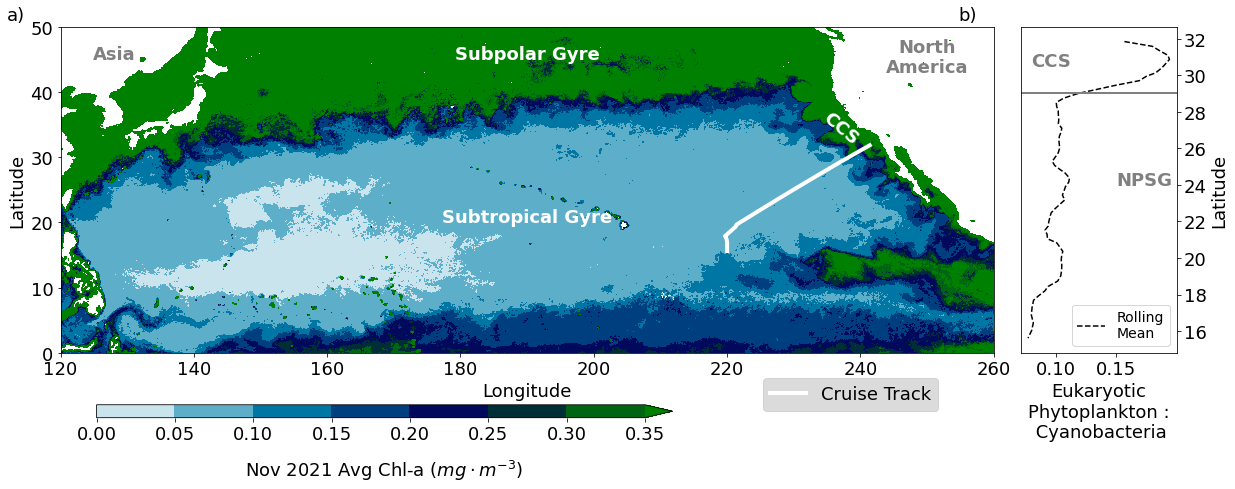

In [34]:
fig,ax = plt.subplots(1,2,figsize=(20,6),gridspec_kw={'width_ratios': [6, 1]})
plt.subplots_adjust(wspace=0.05)

#################### a) MAP #########################
vmin,vmax=0,0.35
levels = np.linspace(vmin, vmax,8) 

plot = ax[0].contourf(ds_wrapped_crop.lon,ds_wrapped_crop.lat,ds_wrapped_crop.chlor_a[0],levels=levels,
                  vmin=vmin,vmax=vmax, extend='max',cmap='ocean_r')

polygon = [[233, 33], [190, 33], [128, 24], [128, 9], [195, 9], [245, 21], [233,33]]
polygon_plot = patches.Polygon(polygon, closed=True,facecolor='none', edgecolor='w',linestyle='--',linewidth=2)
ax[0].add_patch(polygon_plot)
ax[0].plot(metadata_df.longitude,metadata_df.latitude,c='w',linewidth=4,label='Cruise Track')

cax = fig.add_axes([0.15, -0.025, 0.4, 0.03]) #left, bottom, width, height
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal',extend='max') 
cbar.set_label('Nov 2021 Avg Chl-a ($mg\cdot m^{-3}$)',labelpad=15)

ax[0].set_xlim([lon_min,lon_max])
ax[0].set_ylim([0,50])
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')


######## EDDIES ########
count = 0
for poly in buff15km_eddy_polys:
    x, y = poly.exterior.xy
    if count == 0:
        polygon_patch = patches.Polygon(list(zip(x, y)), closed=True, color='k',label='Eddy Edge')
    else:
        polygon_patch = patches.Polygon(list(zip(x, y)), closed=True, color='k')
    
    ax[0].add_patch(polygon_patch)
    count += 1

plot_filled_eddy(ax[0],anti_ds_in_poly,'#ad2713','Anticyclonic Eddy')
plot_filled_eddy(ax[0],cyc_ds_in_poly,'C0','Cyclonic Eddy')


########################

ax[0].legend(bbox_to_anchor=(0.95,-0.05),facecolor='lightgray') 

ax[0].text(190,45,'Subpolar Gyre',horizontalalignment='center',fontweight='bold',c='w')
ax[0].text(190,20,'Subtropical Gyre',horizontalalignment='center',fontweight='bold',c='w')
ax[0].text(237,32,'CCS',horizontalalignment='center',fontweight='bold',c='w',rotation=320)
ax[0].text(128,45,'Asia',horizontalalignment='center',fontweight='bold',c='gray')
ax[0].text(250,43,'North\nAmerica',horizontalalignment='center',fontweight='bold',c='gray')

#################### b) EUK:CYAN #########################

ax[1].plot(np.divide(euk_sum,cyan_sum).rolling(window=9,center=True,min_periods=4).mean(),metadata_df.latitude,
        c='k',linestyle='--',label='Rolling\nMean')
ax[1].plot(np.divide(euk_sum,cyan_sum),metadata_df.latitude,c='green',label='Measured')
ax[1].axhline(29,c='gray',linewidth=2)
ax[1].text(0.06,30.5,'CCS',fontweight='bold',c='gray')
ax[1].text(0.15,24,'NPSG',fontweight='bold',c='gray')

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Eukaryotic\nPhytoplankton :\n Cyanobacteria')

ax[1].legend(fontsize=14)#bbox_to_anchor=(1.2,-0.01))

ax[0].text(112,51,'a)')
ax[1].text(0.02,33,'b)')

#plt.savefig(data_dir + 'G4_traj_paper_figs/chl_map_wG4_transect_v2_no_eddies.pdf',bbox_inches='tight',pad_inches=0,dpi=350)
#plt.savefig(data_dir + 'G4_traj_paper_figs/chl_map_wG4_transect_v2.pdf',bbox_inches='tight',pad_inches=0,dpi=350)

### Fig 3. Eddy Zoom-in

Load data of only the eddies we passed through

In [124]:
anti_df = pd.read_csv(data_dir  + 'AVISO_eddies/AVISO_anti_eddy_G4_crossing_data.csv', converters={'Contour Lons': pd.eval,'Contour Lons': pd.eval})
anti_df = anti_df[anti_df['Center Lat'] <= 29]
anti_df

,Date,Eddy ID,Age (days),Age (frac of life),Speed (m/s),Center Lon,Center Lat,Contour Lons,Contour Lats
1,20211123,799833,12,0.214286,0.1076,225.904083,22.250608,"[225.38, 225.62, 226.1, 226.37, 226.62, 226.95...","[21.57, 21.539999, 21.63, 21.74, 21.77, 21.88,..."


In [125]:
cyc_df = pd.read_csv(data_dir  + 'AVISO_eddies/AVISO_cyc_eddy_G4_crossing_data.csv', converters={'Contour Lons': pd.eval,'Contour Lons': pd.eval})
cyc_df = cyc_df[cyc_df['Center Lat'] <= 29]
cyc_df

,Date,Eddy ID,Age (days),Age (frac of life),Speed (m/s),Center Lon,Center Lat,Contour Lons,Contour Lats
3,20211121,849094,1,0.038462,0.0449,234.287827,27.966232,"[234.12, 233.97, 233.88, 233.87, 233.86, 233.8...","[27.67, 27.88, 28.0, 28.019999, 28.119999, 28...."
4,20211121,831329,224,0.736842,0.1646,232.931168,26.213045,"[232.88, 232.63, 232.20999, 232.05, 231.93, 23...","[25.369999, 25.519999, 25.869999, 26.13, 26.61..."
5,20211122,831329,225,0.740132,0.1693,232.911194,26.217823,"[232.88, 232.63, 232.19, 232.02, 231.9, 231.98...","[25.369999, 25.51, 25.88, 26.14, 26.63, 26.88,..."
6,20211122,844202,63,0.443662,0.0716,228.087341,23.910452,"[227.88, 227.65, 227.64, 227.65, 227.63, 227.6...","[23.279999, 23.369999, 23.39, 23.619999, 23.86..."
7,20211123,823188,326,0.806931,0.1998,223.682907,20.675846,"[222.51, 222.51, 222.62, 222.73999, 222.92, 22...","[19.619999, 19.869999, 20.619999, 20.88, 21.13..."
8,20211124,823188,327,0.809406,0.2029,223.662094,20.700729,"[222.45, 222.54001, 222.53, 222.57, 223.13, 22...","[19.63, 20.119999, 20.369999, 20.619999, 21.66..."
9,20211124,847844,20,0.210526,0.1055,221.653381,19.704439,"[221.62, 221.41, 221.37, 221.19, 221.15, 221.1...","[19.3, 19.369999, 19.41, 19.619999, 19.869999,..."
10,20211126,847844,22,0.231579,0.1055,221.566315,19.704557,"[221.38, 221.35, 221.12, 221.09, 221.04001, 22...","[19.359999, 19.38, 19.58, 19.619999, 19.869999..."
11,20211126,845344,53,0.414062,0.2443,219.415649,17.691402,"[219.38, 219.13, 218.87, 218.79001, 218.68, 21...","[17.08, 17.14, 17.279999, 17.38, 17.619999, 17..."


In [126]:
G4_AVISO_anti_dict = {20211123: [799833]}
G4_AVISO_cyc_dict = {20211121: [849094, 831329],
                    20211122: [844202],
                    20211124: [823188, 847844],
                    20211126: [845344]}

In [127]:
def dimension_edges(dim_array):
    adjustment = float(dim_array[1]-dim_array[0])/2
    adjusted_array = [float(i)-adjustment for i in dim_array]
    adjusted_array.append(dim_array[-1]+adjustment)
    return np.array(adjusted_array)

In [136]:
np.unique(metadata_NPSG_df['date'])

array([20211120, 20211121, 20211122, 20211123, 20211124, 20211126,
       20211127])

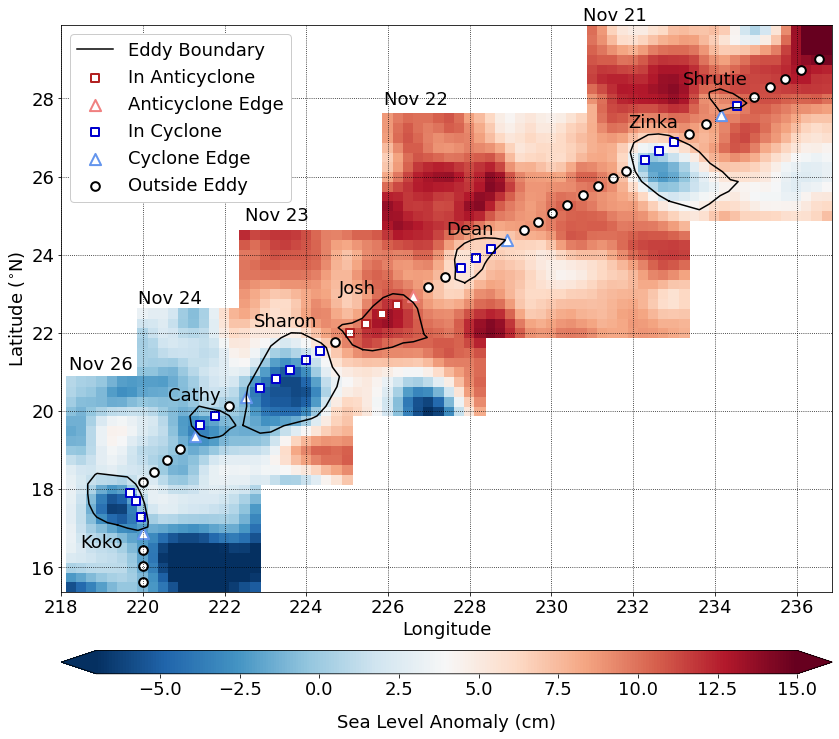

In [138]:
fig,ax = plt.subplots(1,1,figsize=(12,11)) # horizontal, vertical

metadata_NPSG_df = metadata_df[12:]

for d in np.unique(metadata_NPSG_df['date']):
    date_specific_metadata = metadata_NPSG_df[metadata_NPSG_df['date'] == d]
    lats = list(date_specific_metadata['latitude'])
    lons = list(date_specific_metadata['longitude'])

    CMEMS = xr.open_dataset(data_dir + 'CMEMS_data/dt_global_allsat_phy_l4_%s.nc'%(d)) 
    CMEMS_lon_edges = dimension_edges(CMEMS.longitude)
    CMEMS_lat_edges = dimension_edges(CMEMS.latitude)

    buffer = 1.5
    lon_min,lon_max = min(lons)-buffer,max(lons)+buffer
    lat_min,lat_max = min(lats)-buffer,max(lats)+buffer
    lon_inds = np.where((CMEMS_lon_edges >= lon_min) & (CMEMS_lon_edges <= lon_max))
    lat_inds = np.where((CMEMS_lat_edges >= lat_min) & (CMEMS_lat_edges <= lat_max))
    
    if d=='20211120':
        print('Lon max = %s'%(lon_max))
        print('Lat max = %s'%(lat_max))
    
    ############################ PLOT EDDIES ############################

    try:
        anti_tracks = G4_AVISO_anti_dict[d]
        for a in anti_tracks:
            for index, row in anti_df.iterrows():
                if (row['Eddy ID'] == a) & (row['Date'] == d):  
                    contour_lons = row['Contour Lons']
                    contour_lats = row['Contour Lats']
    
                    # Ensure they are lists
                    if isinstance(contour_lons, str):
                        contour_lons = ast.literal_eval(contour_lons)
                    if isinstance(contour_lats, str):
                        contour_lats = ast.literal_eval(contour_lats)
                    ax.plot(contour_lons,contour_lats,c='k',label='Eddy Boundary')
    except:
        pass

    try:
        cyc_tracks = G4_AVISO_cyc_dict[d]
        for a in cyc_tracks:
            for index, row in cyc_df.iterrows():
                if (row['Eddy ID'] == a) & (row['Date'] == d):  
                    contour_lons = row['Contour Lons']
                    contour_lats = row['Contour Lats']
    
                    # Ensure they are lists
                    if isinstance(contour_lons, str):
                        contour_lons = ast.literal_eval(contour_lons)
                    if isinstance(contour_lats, str):
                        contour_lats = ast.literal_eval(contour_lats)
                    ax.plot(contour_lons,contour_lats,c='k')
    except:
        pass
            
    if (str(d) != '20211120') & (str(d) != '20211127'): # for plot simplicity, don't show first and last day
        # Plot the date
        ax.text(min(lons)-buffer,max(lats)+buffer+0.2,'Nov %s'%(str(d)[6:8]),fontsize=fontsize,color='k')

        # Plot SLA
        sla_plot = ax.pcolormesh(CMEMS_lon_edges[lon_inds],CMEMS_lat_edges[lat_inds],CMEMS.sla[0,lat_inds[0],lon_inds[0]]*100,
                                cmap='RdBu_r',vmin=-7,vmax=15,zorder=1,shading='nearest')
    
linewidth = 2
scat_size = 75
ax.scatter([float(i) for i in metadata_NPSG_df[metadata_NPSG_df["in_anti"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_NPSG_df[metadata_NPSG_df["in_anti"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='firebrick',linewidth=linewidth,s=scat_size,marker='s',label='In Anticyclone')

ax.scatter([float(i) for i in metadata_NPSG_df[metadata_NPSG_df["near_anti"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_NPSG_df[metadata_NPSG_df["near_anti"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='lightcoral',linewidth=linewidth,s=scat_size+50,marker='^',label='Anticyclone Edge')

ax.scatter([float(i) for i in metadata_NPSG_df[metadata_NPSG_df["in_cyc"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_NPSG_df[metadata_NPSG_df["in_cyc"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='mediumblue',linewidth=linewidth,s=scat_size,marker='s',label='In Cyclone')

ax.scatter([float(i) for i in metadata_NPSG_df[metadata_NPSG_df["near_cyc"].ne(0)]["longitude"].tolist()],
           [float(i) for i in metadata_NPSG_df[metadata_NPSG_df["near_cyc"].ne(0)]["latitude"].tolist()],
          c='white',edgecolor='cornflowerblue',linewidth=linewidth,s=scat_size+50,marker='^',label='Cyclone Edge')

ax.scatter([float(i) for i in metadata_NPSG_df[metadata_NPSG_df["near_cyc"].eq(0) & 
                                               metadata_NPSG_df["near_anti"].eq(0) & 
                                               metadata_NPSG_df["in_cyc"].eq(0) & 
                                               metadata_NPSG_df["in_anti"].eq(0)]["longitude"].tolist()],
           [float(i) for i in metadata_NPSG_df[metadata_NPSG_df["near_cyc"].eq(0) & 
                                               metadata_NPSG_df["near_anti"].eq(0) & 
                                               metadata_NPSG_df["in_cyc"].eq(0) & 
                                               metadata_NPSG_df["in_anti"].eq(0)]["latitude"].tolist()],
            c='white',edgecolor='k',linewidth=linewidth,s=scat_size,marker='o',label='Outside Eddy')

ax.set_xticks(np.arange(218,238,2))

# Plot eddy names
ax.text(234,28.35,'Shrutie',horizontalalignment='center',color='k')
ax.text(232.5,27.25,'Zinka',horizontalalignment='center',color='k')
ax.text(228,24.5,'Dean',horizontalalignment='center',color='k')
ax.text(225.25,23,'Josh',horizontalalignment='center',color='k')
ax.text(223.5,22.15,'Sharon',horizontalalignment='center',color='k')
ax.text(221.25,20.25,'Cathy',horizontalalignment='center',color='k')
ax.text(219,16.5,'Koko',horizontalalignment='center',color='k')
    
#SLA Colorbar
sla_cbar = plt.colorbar(sla_plot,ax=ax,extend='both',orientation='horizontal',pad=0.08,aspect=30)#,shrink=0.7)
sla_cbar.set_label('Sea Level Anomaly (cm)',labelpad=15)

#Figure params
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude ($^{\circ}}$N)')
plt.grid(zorder=0,c='k',linestyle=':')
plt.legend(loc='upper left',framealpha=1)
plt.tight_layout()

#plt.savefig(data_dir + 'G4_traj_paper_figs/SLA_tile_plot_with_sample_locations_v3.pdf',bbox_inches='tight',pad_inches=0,dpi=350,format='pdf')

### Coherence Grid Map

(see `coh_grid_test.ipynb` to see particle cloud validation)

Computed in `coh_time_of_gridded_particles_v3.py`

In [36]:
traj_ds = xr.open_dataset(data_dir + 'parcels_trajs/2021-11-23_200days_runtime_20min_timestep_0.02_spatial_res_24hr_output_freq_outside_15km_eddy_buff_NPSG_domain.nc')
traj_ds

<xarray.Dataset>
Dimensions:     (obs: 201, traj: 3413051)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    u           (traj, obs) float32 ...
    v           (traj, obs) float32 ...
    vort        (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [37]:
# Regular grid with indeces attached
traj_lats = traj_ds.lat.values
traj_lons = traj_ds.lon.values
lat_to_i = {lat: i for i, lat in enumerate(np.unique(traj_lats[:,0]))}
lon_to_j = {lon: j for j, lon in enumerate(np.unique(traj_lons[:,0]))}

# Map coords to gridded indeces
lat_index = np.array([lat_to_i[lat] for lat in traj_lats[:,0]])
lon_index = np.array([lon_to_j[lon] for lon in traj_lons[:,0]])

# Create a DataFrame for fast lookup
lookup_df = pd.DataFrame({'particle': np.arange(traj_ds.traj.size),
                    'lat_index': lat_index,
                    'lon_index': lon_index})

# MultiIndex for quick lookup (more than one variable can be set to index)
lookup_df.set_index(['lat_index', 'lon_index'], inplace=True)

In [40]:
coh_time_flat = np.load(data_dir+'parcels_trajs/coh_time_of_outside_eddy_test_domain_0.02_res_weighted_mean_dist_7_by_7_cloud.npy')
lookup_df['coh_time'] = coh_time_flat

In [41]:
coh_time_2d = np.full((len(np.unique(lat_index)), len(np.unique(lon_index))), np.nan)

# Assign values into 2D grid using lookup_df's indices
i_inds = lookup_df.index.get_level_values('lat_index').to_numpy()
j_inds = lookup_df.index.get_level_values('lon_index').to_numpy()

# Now fill the 2D array
coh_time_2d[i_inds, j_inds] = lookup_df.coh_time
np.shape(coh_time_2d)

(1199, 5809)

In [42]:
threshold = 90  
mask = coh_time_2d >= threshold
coh_indices = np.argwhere(coh_time_2d >= threshold)
coh_values = coh_time_2d[coh_time_2d >= threshold]

In [43]:
print(len(coh_indices))
print(len(coh_time_flat[~np.isnan(coh_time_flat)]))
print(len(coh_indices)/len(coh_time_flat[~np.isnan(coh_time_flat)]))

5388
49496
0.10885728139647648


In [44]:
init_lons, init_lats = np.unique(traj_lons[:,0]),np.unique(traj_lats[:,0])
cloud_lons = [init_lons[j] for j in j_inds]
cloud_lats = [init_lats[i] for i in i_inds]

Text(122, 35, 'b)')

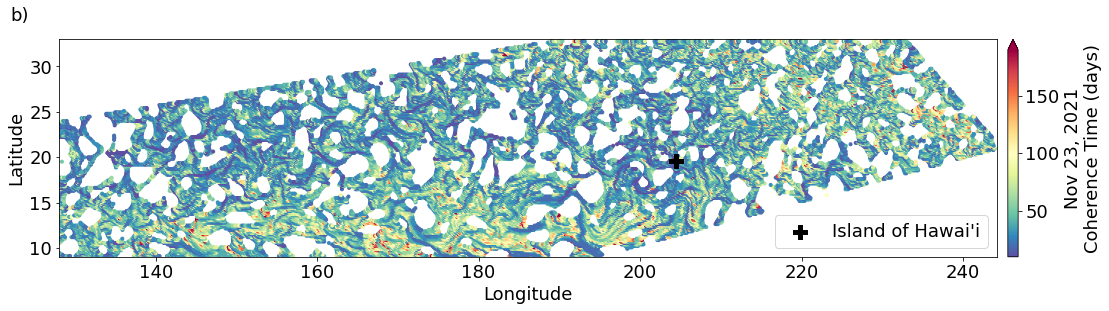

In [139]:
fig,ax = plt.subplots(1,1,figsize=(20,4))

plot = ax.scatter(cloud_lons,cloud_lats,c=coh_time_flat,cmap='Spectral_r',s=9,vmin=10,vmax=190)
cbar = plt.colorbar(plot,ax=ax,pad=0.01,extend='max')
cbar.set_label('Nov 23, 2021\nCoherence Time (days)')

ax.scatter(360-155.5,19.6,marker="P",s=200,c='k',label='Island of Hawai\'i')
#ax.plot(metadata_df.longitude[12:],metadata_df.latitude[12:],c='#5cabcb',linewidth=3,label='Cruise Track (in NPSG)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_xlim(min(lon_array),max(lon_array))
ax.set_ylim(min(lat_array),max(lat_array))

plt.legend(loc='lower right')

Water mass category fractions

In [143]:
# Calculated in `run_parcels_CMEMS_NPSG_outside_eddies.py`
in_eddy_num = 1975999
out_eddy_num = 5389050-1975999

num_clouds = len(coh_time_flat[~np.isnan(coh_time_flat)])
frac_coh = len(coh_indices)/num_clouds # >= 90d coherence
frac_mixed = (num_clouds - len(coh_indices))/num_clouds # < 90d coherence

coh_num = out_eddy_num*frac_coh
mixed_num = out_eddy_num*frac_mixed

print(frac_coh)

0.10885728139647648


Text(-2.5, 1, 'c)')

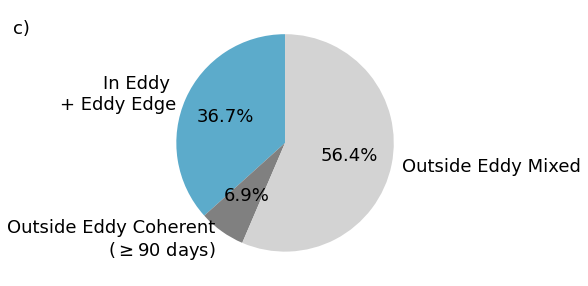

In [138]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

sizes = [in_eddy_num, coh_num, mixed_num]
labels = ['In Eddy \n+ Eddy Edge', 'Outside Eddy Coherent\n($\geq 90$ days)', 'Outside Eddy Mixed']
colors = ['#5cabcb','gray','lightgray']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

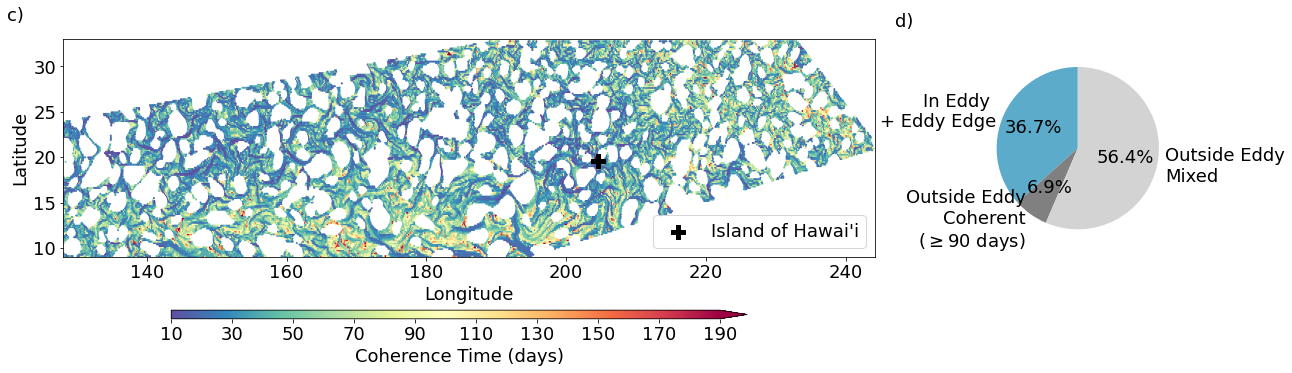

In [170]:
fig,ax = plt.subplots(1,2,figsize=(20,4),gridspec_kw={'width_ratios': [4, 1]})
plt.subplots_adjust(wspace=0.2)

###### MAP ######

plot = ax[0].scatter(cloud_lons,cloud_lats,c=coh_time_flat,cmap='Spectral_r',s=1,vmin=10,vmax=190)

cax = fig.add_axes([0.2, -0.09, 0.4, 0.03]) #left, bottom, width, height
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal',extend='max') 
cbar.set_label('Coherence Time (days)') # Particles Initialized on Nov 23, 2021

ticks = np.arange(10,200,20)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)

ax[0].scatter(360-155.5,19.6,marker="P",s=200,c='k',label='Island of Hawai\'i')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_xlim(min(lon_array),max(lon_array))
ax[0].set_ylim(min(lat_array),max(lat_array))

ax[0].legend(loc='lower right')
ax[0].text(120,35,'c)')

###### PIE CHART ######

sizes = [in_eddy_num, coh_num, mixed_num]
labels = ['In Eddy \n+ Eddy Edge', 'Outside Eddy\nCoherent\n($\geq 90$ days)', 'Outside Eddy\nMixed']
colors = ['#5cabcb','gray','lightgray']
ax[1].pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=90)
ax[1].text(-2.25,1.5,'d)')

#plt.savefig(data_dir + 'G4_traj_paper_figs/coh_time_map_and_pie_chart.pdf',bbox_inches='tight',pad_inches=0,dpi=350)